In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
df = pd.read_csv('iso.csv')
df = df[df['r1_charge_heater'] >= 0]

traces/noisy_83_98_constrained_random.json
(50, 101)
traces/noisy_83_98_constrained_greedy.json
(50, 101)
traces/noisy_83_98_constrained_eg.json
(50, 101)
traces/noisy_83_98_constrained_pi.json
(50, 101)
traces/noisy_83_98_constrained_ei.json
(50, 101)


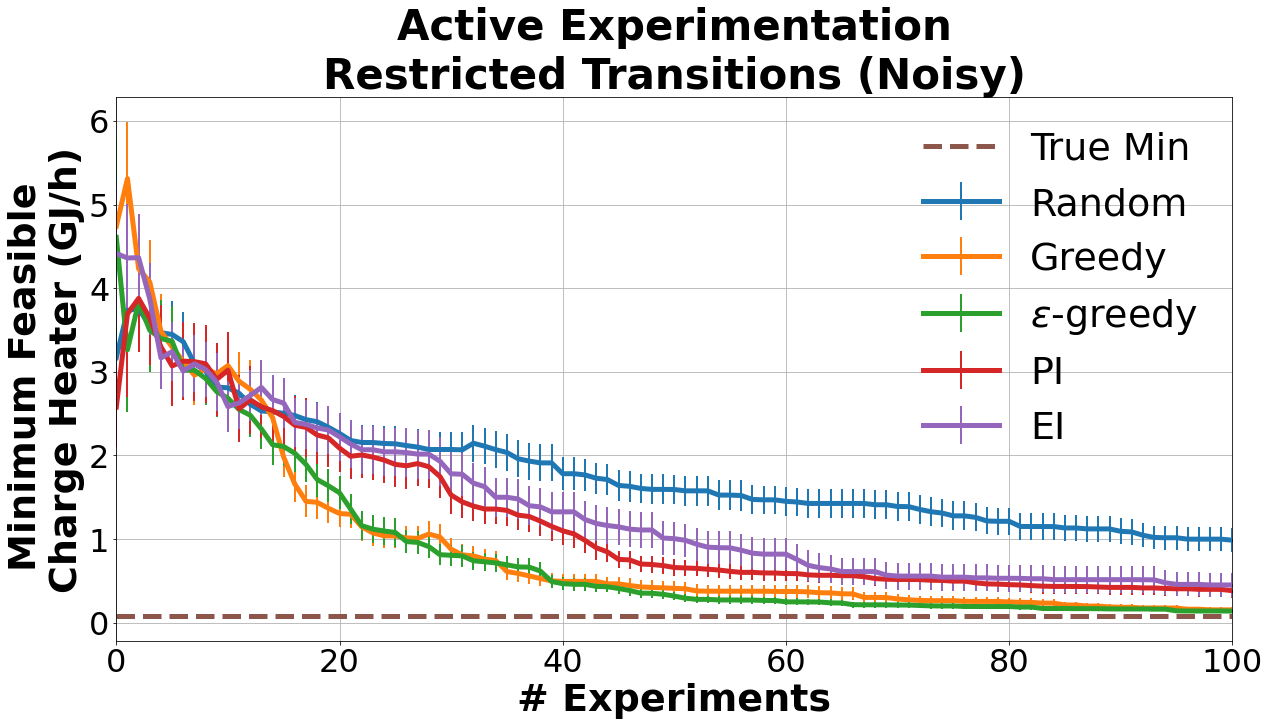

In [6]:
exp = 'noiseless_83_98'
output_path = 'tmp/fig10.tiff'
title = "Active Experimentation\nUnrestricted Transitions (Noiseless)"



exp = 'noisy_83_98'
output_path = 'tmp/fig11.tiff'
title = "Active Experimentation\nUnrestricted Transitions (Noisy)"


exp = 'noisy_83_98_constrained'
output_path = 'tmp/fig12.tiff'
title = "Active Experimentation\nRestricted Transitions (Noisy)"


with open("exp_cfgs/%s.json" % exp, 'r') as f:
    exp_cfg = json.load(f)

min_ron = exp_cfg['min_ron']
min_yield = exp_cfg['min_yield']
models = ['random', 'greedy', 'eg', 'pi', 'ei']
names = ['Random', 'Greedy', '$\epsilon$-greedy', 'PI', 'EI']
#models = ['random']
paths = [(m, "traces/%s_%s.json" % (exp, m), n) for m,n in zip(models, names)]
valid_comb_ix =(df['process_ron'] >= min_ron) & (df['process_yield'] >= min_yield)

f, ax = plt.subplots(1, 1, figsize=(20, 10))
for _,p,name in paths:
    print(p)
    with open(p, 'r') as f:
        results = json.load(f)

    trace_chs = []
    for r in results['obs_traces']:
        r = np.array(r)
        fix = (r[:,1] >= min_ron) & (r[:,2] >= min_yield)
        r[~fix,0] = np.inf
        trace_chs.append(np.minimum.accumulate(r[:,0]))
    
    #inputs = df.iloc[results['traces'][0]]
    #print(inputs.iloc[10:])
    trace_chs = np.array(trace_chs) / (1000*1000)
    print(trace_chs.shape)
    trace_chs[np.isinf(trace_chs)] = np.nan
    reps = np.sum(~np.isnan(trace_chs), axis=0)
    
    mean_trace = np.nanmean(trace_chs, axis=0)
    stderr_trace = np.nanstd(trace_chs, axis=0, ddof=1) / np.sqrt(reps)
    
    ax.errorbar(np.arange(mean_trace.shape[0]), mean_trace, yerr=stderr_trace, linewidth=5, label=name, marker='o', markersize=2, elinewidth=2)
    #ax.plot(, )

ax.plot(np.arange(mean_trace.shape[0]), np.ones(mean_trace.shape[0]) * 
        np.min(df[valid_comb_ix]['r1_charge_heater'] / (1000*1000)), linewidth=5, linestyle='--', label='True Min')
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('# Experiments', fontsize=38, fontweight='bold')
ax.set_ylabel('Minimum Feasible \nCharge Heater (GJ/h)', fontsize=38, fontweight='bold')
ax.grid(True)
ax.set_title(title, fontsize=42, fontweight='bold')
ax.legend(fontsize=38, frameon=False)
ax.set_xlim([0,100])
plt.savefig(output_path, bbox_inches='tight', transparent=True, pad_inches=0.05, dpi=300, pil_kwargs={"compression": "tiff_lzw"})


In [150]:
np.all(np.array([[1,11],[3,4]]) > [0, 10], axis=1)

array([ True, False])

In [20]:
path = "traces/noisy_83_98_constrained_ei.json"

with open(path, 'r') as f:
    results = json.load(f)

    trace_chs = []
    for r in results['obs_traces']:
        r = np.array(r)
        fix = (r[:,1] >= min_ron) & (r[:,2] >= min_yield)
        r[~fix,0] = np.inf
        trace_chs.append(np.minimum.accumulate(r[:,0]))
    
    #inputs = df.iloc[results['traces'][0]]
    #print(inputs.iloc[10:])
    trace_chs = np.array(trace_chs) / (1000*1000)
    print(trace_chs.shape)

(50, 101)


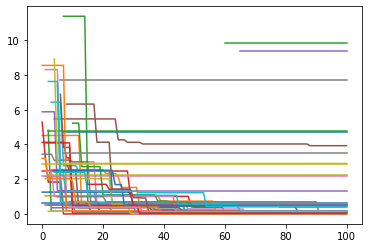

In [21]:
f, ax = plt.subplots(1, 1)
for i in range(50):
    ax.plot(np.arange(trace_chs.shape[1]), trace_chs[i,:])